# Consumer Complaint Classification with LSTM
This project uses real-time complaint data from the CFPB Consumer Complaints API. We build an LSTM model to predict the product type based on consumer complaint narratives.

### Goals
- Extract complaint narratives from the API
- Clean and preprocess the text
- Train an LSTM model to classify complaint types
- Evaluate performance using a confusion matrix and classification report

## Step 1: Load Data from CFPB API

In [1]:
import requests
import pandas as pd
import json

url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/"
params = {
    "size": 100,
    "no_aggs": "true",
    "searchTerm": "",
    "has_narrative": "true"
}
response = requests.get(url, params=params)
data = response.json()
records = [doc["_source"] for doc in data["hits"]["hits"]]
df = pd.DataFrame(records)
df = df[df["complaint_what_happened"].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)
df.head()

,product,complaint_what_happened,date_sent_to_company,issue,sub_product,zip_code,tags,has_narrative,complaint_id,timely,consumer_consent_provided,company_response,submitted_via,company,date_received,state,consumer_disputed,company_public_response,sub_issue
0,Credit card,Chae bank called me about a fraudulent case ap...,2024-09-03T12:00:00-05:00,Getting a credit card,General-purpose credit card or charge card,01923,None,True,9999983,Yes,Consent provided,Closed with explanation,Web,JPMORGAN CHASE & CO.,2024-09-03T12:00:00-05:00,MA,N/A,None,Card opened without my consent or knowledge
1,Credit reporting or other personal consumer re...,The inclusion of these unauthorized accounts a...,2024-09-03T12:00:00-05:00,Incorrect information on your report,Credit reporting,77064,None,True,9999982,Yes,Consent provided,Closed with explanation,Web,"EQUIFAX, INC.",2024-09-03T12:00:00-05:00,TX,N/A,None,Account status incorrect
2,Credit reporting or other personal consumer re...,I respectfully seek your comprehension regardi...,2024-09-03T12:00:00-05:00,Incorrect information on your report,Credit reporting,19138,None,True,9999977,Yes,Consent provided,Closed with explanation,Web,Experian Information Solutions Inc.,2024-09-03T12:00:00-05:00,PA,N/A,Company has responded to the consumer and the ...,Account status incorrect
3,Debt collection,"Upon reviewing my credit report, I identified ...",2024-09-03T12:00:00-05:00,Attempts to collect debt not owed,I do not know,29063,None,True,9999975,Yes,Consent provided,Closed with explanation,Web,"EQUIFAX, INC.",2024-09-03T12:00:00-05:00,SC,N/A,None,Debt is not yours
4,Debt collection,sent letters to aargon agency asking for valid...,2024-09-09T12:00:00-05:00,Written notification about debt,Other debt,480XX,Servicemember,True,9999970,Yes,Consent provided,Closed with explanation,Web,"Aargon Agency, Inc.",2024-09-03T12:00:00-05:00,MI,N/A,Company has responded to the consumer and the ...,Didn't receive notice of right to dispute


## Step 2: Clean and Preprocess Text

In [2]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    return " ".join([w for w in words if w not in stop_words])

df["clean_text"] = df["complaint_what_happened"].apply(clean_text)
df[["product", "clean_text"]].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nyouseflavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product,clean_text
0,Credit card,chae bank called fraudulent case application g...
1,Credit reporting or other personal consumer re...,inclusion unauthorized accounts inquiries caus...
2,Credit reporting or other personal consumer re...,respectfully seek comprehension regarding late...
3,Debt collection,upon reviewing credit report identified multip...
4,Debt collection,sent letters aargon agency asking validation d...


##  Step 3: Tokenize Text and Encode Labels

In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["product"])

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])
X = pad_sequences(sequences, maxlen=200)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 4: Train LSTM Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

C:\Users\nyouseflavi\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 650ms/step - accuracy: 0.4180 - loss: 1.3747 - val_accuracy: 0.8500 - val_loss: 1.3211
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.9539 - loss: 1.2880 - val_accuracy: 0.8500 - val_loss: 1.2317
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.9461 - loss: 1.1637 - val_accuracy: 0.8500 - val_loss: 1.0843
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.9617 - loss: 0.9441 - val_accuracy: 0.8500 - val_loss: 0.8285
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9461 - loss: 0.5839 - val_accuracy: 0.8500 - val_loss: 0.5499


## Step 5: Evaluate Model with Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


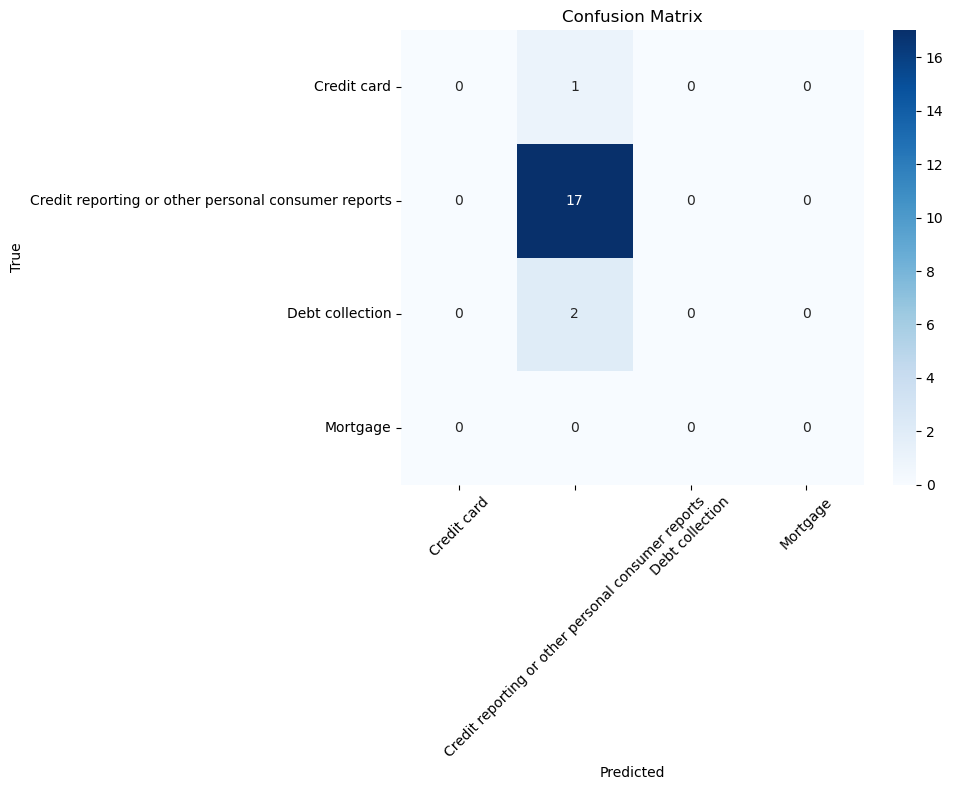

                                                     precision    recall  f1-score   support

                                        Credit card       0.00      0.00      0.00         1
Credit reporting or other personal consumer reports       0.85      1.00      0.92        17
                                    Debt collection       0.00      0.00      0.00         2
                                           Mortgage       0.00      0.00      0.00         0

                                           accuracy                           0.85        20
                                          macro avg       0.21      0.25      0.23        20
                                       weighted avg       0.72      0.85      0.78        20



In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

labels = list(range(len(label_encoder.classes_)))
names = label_encoder.classes_
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, labels=labels, target_names=names, zero_division=0))

##  Step 6: Make Predictions on New Complaints

In [6]:
def predict_product(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=200)
    pred = model.predict(padded)
    return label_encoder.inverse_transform([np.argmax(pred)])

# Test example
sample = "I was charged late fees for no reason even though I paid on time."
predict_product(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


array(['Credit reporting or other personal consumer reports'],
      dtype=object)

## Conclusion
In this project, we successfully:
- Pulled real consumer complaints from a public API
- Cleaned and tokenized complaint narratives
- Trained a deep learning model (LSTM) to classify product types
- Evaluated model accuracy and interpreted results with a confusion matrix

This project is a great example of using real-world NLP and deep learning on public datasets.